# Transfer Learning with MobileNetV2

In [2]:
# Standard library imports
import os  # For handling file and directory operations

# Third-party library imports
import numpy as np  # For numerical computations
import matplotlib.pyplot as plt  # For plotting and visualization

# TensorFlow core and Keras imports
import tensorflow as tf  # For machine learning and deep learning tasks
import tensorflow.keras.layers as tfl  # For building neural network layers

# TensorFlow preprocessing utilities
from tensorflow.keras.preprocessing import image_dataset_from_directory  # For loading datasets from directories
from tensorflow.keras.layers import RandomFlip, RandomRotation  # For data augmentation


2024-12-22 10:11:02.538685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734844262.569278   16259 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734844262.578576   16259 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-22 10:11:02.609775: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 1.1 Create the Dataset and split it into Training and validation set

In [4]:
# Define constants for batch size and image dimensions
BATCH_SIZE = 32  # Number of images to process in a batch
IMG_SIZE = (160, 160)  # Resize all images to 160x160 pixels

# Directory containing the dataset
directory = "dataset/"  # Path to the dataset folder

# Load the training dataset with an 80-20 train-validation split
train_dataset = image_dataset_from_directory(
    directory,
    shuffle=True,  # Randomly shuffle the dataset to improve model generalization
    batch_size=BATCH_SIZE,  # Process data in batches for efficient training
    image_size=IMG_SIZE,  # Resize images to uniform dimensions
    validation_split=0.2,  # Allocate 20% of data for validation
    subset='training',  # Specify this subset as training data
    seed=42  # Set seed for reproducibility of the split
)

# Load the validation dataset
validation_dataset = image_dataset_from_directory(
    directory,
    shuffle=True,  # Shuffle to reduce validation bias
    batch_size=BATCH_SIZE,  # Process data in batches for efficiency
    image_size=IMG_SIZE,  # Resize images to uniform dimensions
    validation_split=0.2,  # Use the same split ratio as training
    subset='validation',  # Specify this subset as validation data
    seed=42  # Set seed for reproducibility
)


Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


2024-12-22 10:11:05.457715: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


2024-12-22 10:11:05.905085: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


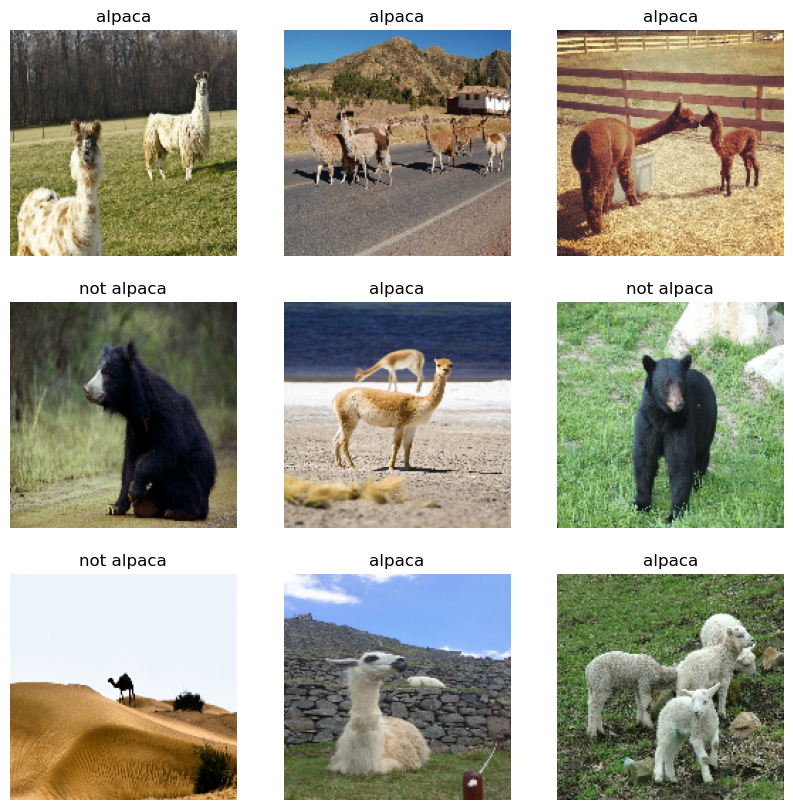

In [5]:
# Extract class names from the training dataset
class_names = train_dataset.class_names  # Retrieve the class labels from the dataset

# Visualize a batch of training images with their labels
plt.figure(figsize=(10, 10))  # Set the figure size
for images, labels in train_dataset.take(1):  # Take one batch from the training dataset
    for i in range(9):  # Display the first 9 images
        ax = plt.subplot(3, 3, i + 1)  # Create a 3x3 grid of subplots
        plt.imshow(images[i].numpy().astype("uint8"))  # Display the image as a uint8 array
        plt.title(class_names[labels[i]])  # Add the corresponding class label as the title
        plt.axis("off")  # Remove the axis for better visualization


## 2 - Preprocess and Augment Training Data

In [7]:
# Enable automatic tuning of parallelism and prefetching
AUTOTUNE = tf.data.AUTOTUNE

# Apply prefetching to the training dataset to improve performance
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)


### data_augmenter

In [9]:
def data_augmenter():
    """
    Creates a Sequential model with data augmentation layers.
    
    Returns:
        tf.keras.Sequential: A Sequential model with data augmentation layers.
    """
    # Define a sequential model for data augmentation
    data_augmentation = tf.keras.Sequential([
        RandomFlip("horizontal"),  # Randomly flip images horizontally
        RandomRotation(0.2)        # Randomly rotate images up to 20%
    ])
    
    return data_augmentation


In [10]:
# Instantiate the data augmenter
augmenter = data_augmenter()

# Validate the first layer is RandomFlip with the correct mode
assert augmenter.layers[0].name.startswith('random_flip'), "First layer must be RandomFlip"
assert augmenter.layers[0].mode == 'horizontal', "RandomFlip parameter must be 'horizontal'"

# Validate the second layer is RandomRotation with the correct factor range
rotation_layer = augmenter.layers[1]
assert rotation_layer.name.startswith('random_rotation'), "Second layer must be RandomRotation"

# Check if the rotation factor matches the expected range
expected_factor = (-0.2, 0.2)
actual_factor = rotation_layer.factor
assert actual_factor == expected_factor, f"Rotation factor must be {expected_factor}, but got {actual_factor}"

# Indicate all tests passed with an informative message
print("\033[92mAll assertions passed! The data augmenter layers are correctly configured.")


All assertions passed! The data augmenter layers are correctly configured.


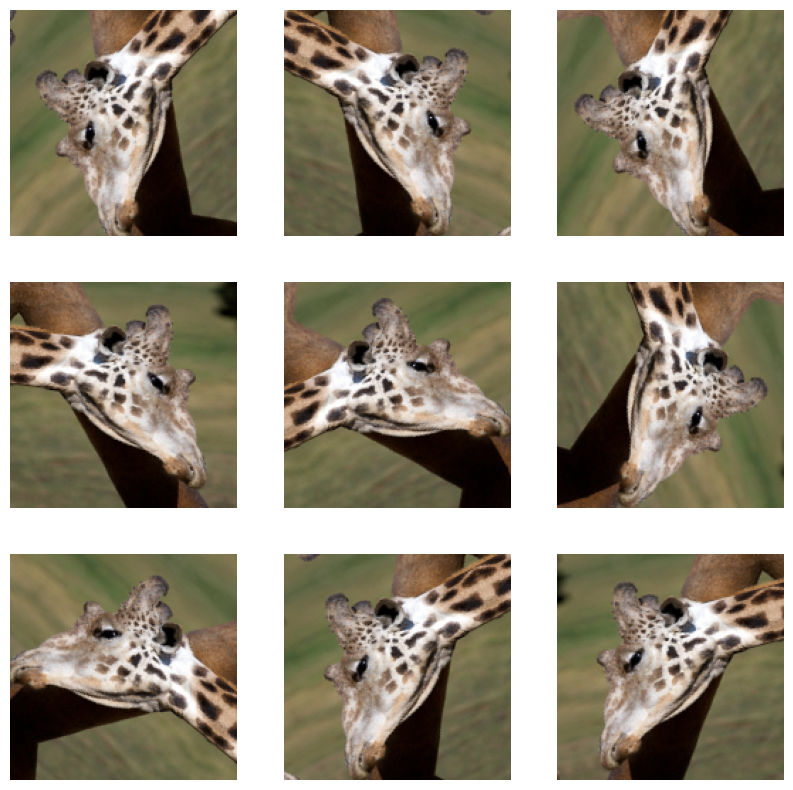

2024-12-22 10:11:08.720049: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
# Assuming data_augmenter is defined elsewhere, creating an instance of it
data_augmentation = data_augmenter()

# Take a single image from the dataset
for image, _ in train_dataset.take(1):
    # Set up the figure size for the subplot
    plt.figure(figsize=(10, 10))

    # Extract the first image from the batch
    first_image = image[0]

    # Generate 9 augmented images and display them
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        
        # Display the augmented image normalized to [0, 1]
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')  # Turn off axis labels for a cleaner view

    plt.show()  # Display all subplots at once


In [12]:
# Load the MobileNetV2 preprocessing function from TensorFlow
# This function scales input pixel values from [0, 255] to the range expected by MobileNetV2
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


## 3 - Using MobileNetV2 for Transfer Learning

### 3.1 - Inside a MobileNetV2 Convolutional Building Block

In [15]:
# Define the shape of the input images, including 3 channels for RGB
IMG_SHAPE = IMG_SIZE + (3,)

# Load the MobileNetV2 model pre-trained on the ImageNet dataset
# - input_shape: Specifies the shape of input images
# - include_top: Whether to include the fully connected layer at the top of the network
# - weights: Load pre-trained weights from ImageNet
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=True,  # Keep the classifier layers for transfer learning or evaluation
    weights='imagenet'  # Use pre-trained weights
)


In [16]:
# Display the model architecture summary
# This will print out details such as the layer types, output shapes, and the number of parameters
base_model.summary()


Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [17]:
# Get the total number of layers in the base model
nb_layers = len(base_model.layers)

# Print the names of the second-to-last and last layers of the model
print(f"Second-to-last layer: {base_model.layers[-2].name}")
print(f"Last layer: {base_model.layers[-1].name}")


Second-to-last layer: global_average_pooling2d
Last layer: predictions


In [18]:
# Fetch a single batch of images and labels from the training dataset
image_batch, label_batch = next(iter(train_dataset))

# Extract features by passing the image batch through the base model
# The base model outputs feature representations from its layers
feature_batch = base_model(image_batch)

# Output the shape of the feature batch for verification (e.g., batch size, feature dimensions)
print(f"Feature batch shape: {feature_batch.shape}")


Feature batch shape: (32, 1000)


In [19]:
#Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0], dtype=int32)>

In [20]:
# Freeze the base model to prevent its weights from being updated during training
base_model.trainable = False

# Create a TensorFlow variable from the image batch
# This allows for potential future operations like gradient computation or optimization
image_var = tf.Variable(image_batch)

# Use the base model to make predictions on the image batch
# The output is typically a probability distribution over classes
pred = base_model(image_var)

# Decode the predictions into human-readable class labels
# `top=2` limits the output to the top 2 predicted classes for each image
decoded_predictions = tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

# Print the decoded predictions
for i, prediction in enumerate(decoded_predictions):
    print(f"Image {i+1}: {prediction}")


Image 1: [('n04589890', 'window_screen', 0.42582113), ('n02708093', 'analog_clock', 0.09275583)]
Image 2: [('n04589890', 'window_screen', 0.2398583), ('n03887697', 'paper_towel', 0.14802672)]
Image 3: [('n04589890', 'window_screen', 0.7449452), ('n03598930', 'jigsaw_puzzle', 0.021948697)]
Image 4: [('n04589890', 'window_screen', 0.33545953), ('n03530642', 'honeycomb', 0.076289825)]
Image 5: [('n04589890', 'window_screen', 0.2732727), ('n03733281', 'maze', 0.08846987)]
Image 6: [('n04589890', 'window_screen', 0.6745231), ('n03530642', 'honeycomb', 0.07659909)]
Image 7: [('n04589890', 'window_screen', 0.7912843), ('n04209239', 'shower_curtain', 0.092416994)]
Image 8: [('n04589890', 'window_screen', 0.16462964), ('n03598930', 'jigsaw_puzzle', 0.087491855)]
Image 9: [('n03598930', 'jigsaw_puzzle', 0.37021372), ('n04589890', 'window_screen', 0.099569194)]
Image 10: [('n04589890', 'window_screen', 0.61616427), ('n03887697', 'paper_towel', 0.05487705)]
Image 11: [('n03530642', 'honeycomb', 0.

### 3.2 - Layer Freezing with the Functional API

### alpaca_model

In [23]:
# GRADED FUNCTION
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    """
    Define a tf.keras model for binary classification based on the MobileNetV2 model.

    Arguments:
        image_shape -- Tuple specifying the width and height of the input images (e.g., (224, 224)).
        data_augmentation -- Data augmentation function to apply during training.

    Returns:
        model -- A tf.keras.Model instance configured for binary classification.
    """
    # Ensure the input shape includes the RGB channels (3)
    input_shape = image_shape + (3,)
    
    # Initialize the base MobileNetV2 model with pretrained ImageNet weights
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,  # Exclude the top layer to customize for binary classification
        weights="imagenet"  # Use pretrained weights for feature extraction
    )
    
    # Freeze the base model to prevent updating its weights during training
    base_model.trainable = False

    # Define the input layer for the model
    inputs = tf.keras.Input(shape=input_shape)

    # Apply data augmentation to the input layer
    x = data_augmentation(inputs)

    # Preprocess the inputs to align with MobileNetV2's training format
    x = preprocess_input(x)

    # Pass the preprocessed inputs through the base model
    # Set `training=False` to avoid updating batch normalization statistics
    x = base_model(x, training=False)

    # Use global average pooling to reduce the spatial dimensions of feature maps
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Add a dropout layer to reduce overfitting
    x = tf.keras.layers.Dropout(0.2)(x)

    # Define the output layer with a single neuron for binary classification
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    # Create the model by specifying the inputs and outputs
    model = tf.keras.Model(inputs, outputs)

    return model


In [24]:
# Instantiate the binary classification model using the alpaca_model function.
# Pass the image size and data augmentation function as parameters.
model2 = alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmentation)


In [25]:
# # Import utility functions for model summary comparison and visualization
# from test_utils import summary, comparator

# # Define the expected summary of the alpaca model for comparison
# alpaca_summary = [
#     ['InputLayer', [(None, 160, 160, 3)], 0],  # Input layer with the specified image dimensions
#     ['Sequential', (None, 160, 160, 3), 0],  # Data augmentation layer
#     ['TensorFlowOpLayer', [(None, 160, 160, 3)], 0],  # Preprocessing layer
#     ['TensorFlowOpLayer', [(None, 160, 160, 3)], 0],  # Base model preprocessing layer
#     ['Functional', (None, 5, 5, 1280), 2257984],  # Feature extraction layer (base model output)
#     ['GlobalAveragePooling2D', (None, 1280), 0],  # Pooling layer to reduce dimensions
#     ['Dropout', (None, 1280), 0, 0.2],  # Dropout layer for regularization (20% dropout rate)
#     ['Dense', (None, 1), 1281, 'linear']  # Final dense layer for binary classification
# ]

# # Compare the actual model summary with the expected alpaca_summary
# comparator(summary(model2), alpaca_summary)

# # Print the layers of the model summary for detailed inspection
# for layer in summary(model2):
#     print(layer)


In [26]:
# Define the base learning rate for the optimizer
base_learning_rate = 0.01

# Compile the model with Adam optimizer, binary cross-entropy loss, and accuracy metric
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),  # Adam optimizer with specified learning rate
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # Binary cross-entropy loss for logits output
    metrics=['accuracy']  # Evaluate accuracy during training
)


In [27]:
# Set the number of epochs for initial training
initial_epochs = 5

# Train the model using the training dataset, validate on the validation dataset, and track training history
history = model2.fit(
    train_dataset,               # Dataset for training
    validation_data=validation_dataset,  # Dataset for validation during training
    epochs=initial_epochs        # Number of training epochs
)


Epoch 1/5


/home/muhammad-saqib/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:750: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 856ms/step - accuracy: 0.6161 - loss: 0.9178 - val_accuracy: 0.8923 - val_loss: 0.2929
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 601ms/step - accuracy: 0.8100 - loss: 0.3880 - val_accuracy: 0.9692 - val_loss: 0.1662
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 634ms/step - accuracy: 0.8818 - loss: 0.2562 - val_accuracy: 0.9692 - val_loss: 0.1149
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 593ms/step - accuracy: 0.9127 - loss: 0.1807 - val_accuracy: 0.9692 - val_loss: 0.0960
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 593ms/step - accuracy: 0.9278 - loss: 0.1879 - val_accuracy: 0.9846 - val_loss: 0.1074


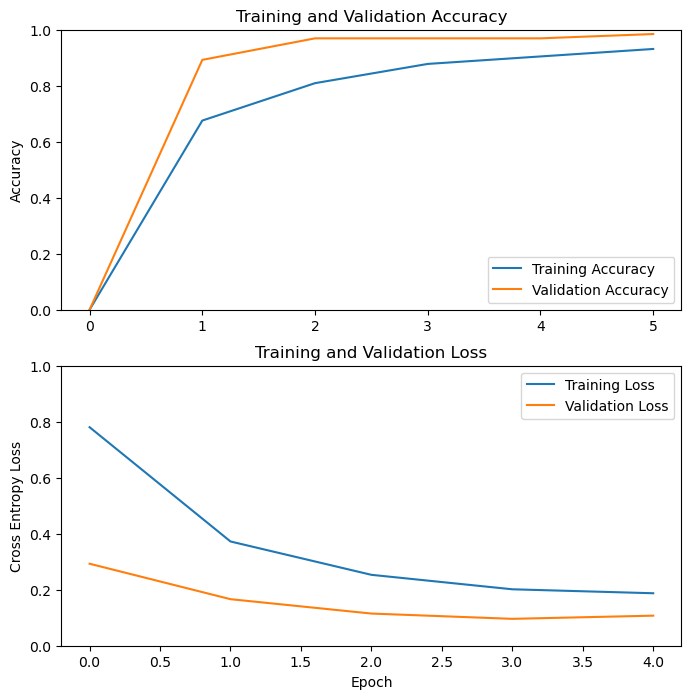

In [28]:
# Append a starting value of 0 for better visualization of accuracy over epochs
acc = [0.0] + history.history['accuracy']
val_acc = [0.0] + history.history['val_accuracy']

# Extract training and validation loss from history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Set the figure size for the plots
plt.figure(figsize=(8, 8))

# Plot Training and Validation Accuracy
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')  # Place the legend at the lower-right corner
plt.ylabel('Accuracy')
plt.ylim([0, 1])  # Ensure y-axis is within the valid range for accuracy
plt.title('Training and Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')  # Place the legend at the upper-right corner
plt.ylabel('Cross Entropy Loss')
plt.ylim([0, 1.0])  # Set loss plot y-axis range
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')

# Display the plots
plt.show()


In [29]:
# List of class labels corresponding to the dataset categories
class_names


['alpaca', 'not alpaca']

### 3.3 - Fine-tuning the Model

In [31]:
# Display a summary of the base model's architecture, including the number of layers, output shapes, and parameter counts
base_model.summary()


Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,538,984 (13.50 MB)

In [32]:
# Enable training for the base model
base_model.trainable = True

# Display the number of layers in the base model
print(f"Number of layers in the base model: {len(base_model.layers)}")

# Set the layer index from which to begin fine-tuning
fine_tune_at = 126

# Freeze all layers in the base model up to the specified layer index
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False  # Mark layers as non-trainable

# Define the BinaryCrossentropy loss function with logits
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Configure the Adam optimizer with a reduced learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate * 0.1)

# Specify accuracy as the evaluation metric
metrics = ['accuracy']

# Compile the model with the defined loss function, optimizer, and evaluation metrics
model2.compile(
    loss=loss_function,
    optimizer=optimizer,
    metrics=metrics
)


Number of layers in the base model: 156


In [33]:
# Validate that the loss function is BinaryCrossentropy with from_logits=True
assert isinstance(loss_function, tf.keras.losses.BinaryCrossentropy), "The loss function must be BinaryCrossentropy"
assert loss_function.from_logits, "The BinaryCrossentropy loss must be set with from_logits=True"

# Validate that the optimizer is Adam and the learning rate is correctly set
assert isinstance(optimizer, tf.keras.optimizers.Adam), "The optimizer must be Adam"
assert optimizer.learning_rate == base_learning_rate / 10, "The learning rate is not set correctly"

# Validate that the evaluation metric is accuracy
assert metrics[0] == 'accuracy', "The evaluation metric must be accuracy"

# Print success message if all assertions pass
print('\033[92mValidation successful: Loss function, optimizer, and metrics are correctly configured.')


Validation successful: Loss function, optimizer, and metrics are correctly configured.


In [34]:
# Define the number of epochs for fine-tuning
fine_tune_epochs = 5

# Calculate the total number of epochs (initial + fine-tuning)
total_epochs = initial_epochs + fine_tune_epochs

# Train the model for fine-tuning
history_fine = model2.fit(
    train_dataset,                # Training dataset
    epochs=total_epochs,          # Total epochs to train
    initial_epoch=history.epoch[-1],  # Start fine-tuning from the last trained epoch
    validation_data=validation_dataset  # Validation dataset for evaluation
)


Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8979 - loss: 0.2668 - val_accuracy: 1.0000 - val_loss: 0.0820
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 645ms/step - accuracy: 0.9302 - loss: 0.2192 - val_accuracy: 1.0000 - val_loss: 0.0788
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 639ms/step - accuracy: 0.9220 - loss: 0.2152 - val_accuracy: 0.9846 - val_loss: 0.0928
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 627ms/step - accuracy: 0.9498 - loss: 0.1322 - val_accuracy: 1.0000 - val_loss: 0.0806
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 641ms/step - accuracy: 0.9653 - loss: 0.1237 - val_accuracy: 1.0000 - val_loss: 0.0787
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 640ms/step - accuracy: 0.9468 - loss: 0.1204 - val_accuracy: 0.9846 - val_loss: 0.0979


In [35]:
# Extend the accuracy and validation accuracy lists with the fine-tuning results
acc.extend(history_fine.history['accuracy'])
val_acc.extend(history_fine.history['val_accuracy'])

# Extend the loss and validation loss lists with the fine-tuning results
loss.extend(history_fine.history['loss'])
val_loss.extend(history_fine.history['val_loss'])


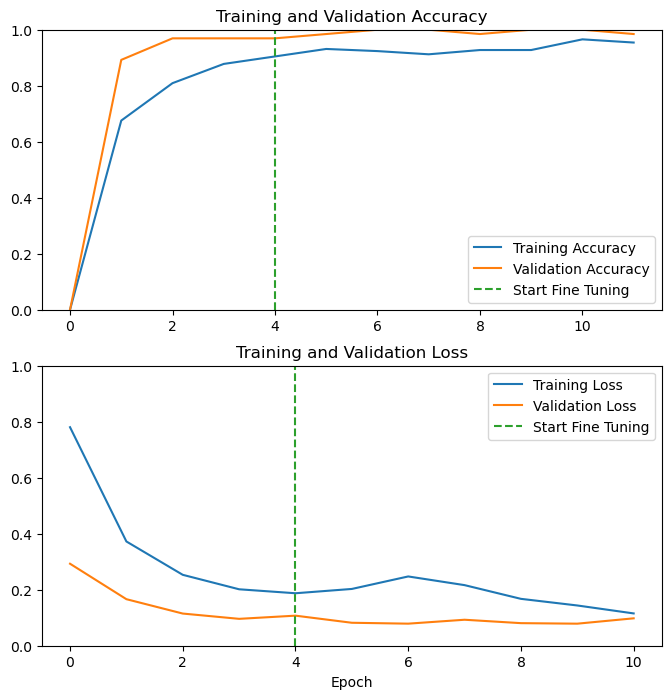

In [36]:
# Create a figure with specified dimensions for visualization
plt.figure(figsize=(8, 8))

# Plot training and validation accuracy
plt.subplot(2, 1, 1)  # Create the first subplot for accuracy
plt.plot(acc, label='Training Accuracy')  # Plot training accuracy
plt.plot(val_acc, label='Validation Accuracy')  # Plot validation accuracy
plt.ylim([0, 1])  # Set y-axis limits for accuracy
plt.plot([initial_epochs - 1, initial_epochs - 1],  # Mark the start of fine-tuning
         plt.ylim(), linestyle='--', label='Start Fine Tuning')
plt.legend(loc='lower right')  # Position the legend
plt.title('Training and Validation Accuracy')  # Add a title to the plot

# Plot training and validation loss
plt.subplot(2, 1, 2)  # Create the second subplot for loss
plt.plot(loss, label='Training Loss')  # Plot training loss
plt.plot(val_loss, label='Validation Loss')  # Plot validation loss
plt.ylim([0, 1.0])  # Set y-axis limits for loss
plt.plot([initial_epochs - 1, initial_epochs - 1],  # Mark the start of fine-tuning
         plt.ylim(), linestyle='--', label='Start Fine Tuning')
plt.legend(loc='upper right')  # Position the legend
plt.title('Training and Validation Loss')  # Add a title to the plot
plt.xlabel('Epoch')  # Label the x-axis
plt.show()  # Display the plots
